Andrian Tambunan - 5025211018<br />
Revanantyo Dwigantara - 5025211113<br />
Danno Denis - 5025211027<br />

# Setup

Install package-package yang dibutuhkan.
Transformers digunakan untuk melakukan processing pada model NLP dan CV.



In [1]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 61.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.7/311.7 kB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 107.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 92.2 MB/s eta 0:00:00


Import package-package yang dibutuhkan.

In [2]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [10]:
df = pd.read_csv("ebay_reviews.csv")
df.head()

,category,review title,review content,rating
0,Headsets,Wireless gaming headset,This gaming headset ticks all the boxes # look...,5
1,Headsets,"Good for those with a big head, low budget","Easy setup, rated for 6 hours battery but mine...",3
2,Headsets,MezumiWireless Gaming Headset,I originally bought this wireless headset for ...,5
3,Headsets,HW- S2 great headset.,"This is my 2nd Mezumi headset, It kills the fi...",5
4,Headsets,BEST HEADPHONES I'VE PURCHASED IN MY ENTIRE LIFE,This is probably the best headset I've purchas...,5


# Exploratory Data Analysis

In [11]:
df.shape

(44756, 4)

Cek data apakah null atau tidak.

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44756 entries, 0 to 44755
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   category        44756 non-null  object
 1   review title    44756 non-null  object
 2   review content  44756 non-null  object
 3   rating          44756 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 1.4+ MB


Karena tidak ada null, maka dataset tidak perlu treatment

Lalu, kita plot kolom rating untuk melihat distribusi pada rating.

<Axes: title={'center': 'Score Distribution'}, xlabel='Score', ylabel='Count'>

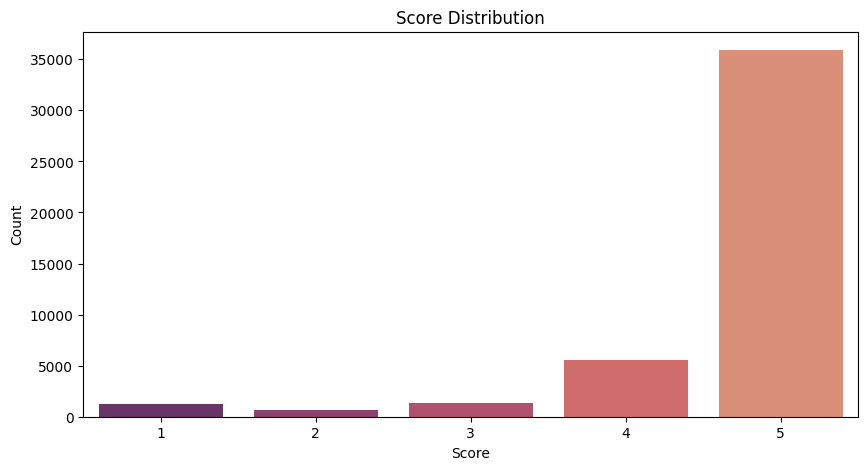

In [13]:
fig = plt.figure(figsize=(10, 5))
plt.title('Score Distribution')
plt.xlabel('Score')
plt.ylabel('Count')
sns.barplot(x=df['rating'].value_counts().keys().to_list(), y=df['rating'].value_counts().to_list(), palette='flare_r')

Ubah rating 1 dan 2 menjadi negative, 3 neutral, lalu 4 dan 5 positive.

In [14]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0 # negative
  elif rating == 3:
    return 1 # neutral
  else:
    return 2 # positive

df['sentiment'] = df.rating.apply(to_sentiment)

In [15]:
df.head()

,category,review title,review content,rating,sentiment
0,Headsets,Wireless gaming headset,This gaming headset ticks all the boxes # look...,5,2
1,Headsets,"Good for those with a big head, low budget","Easy setup, rated for 6 hours battery but mine...",3,1
2,Headsets,MezumiWireless Gaming Headset,I originally bought this wireless headset for ...,5,2
3,Headsets,HW- S2 great headset.,"This is my 2nd Mezumi headset, It kills the fi...",5,2
4,Headsets,BEST HEADPHONES I'VE PURCHASED IN MY ENTIRE LIFE,This is probably the best headset I've purchas...,5,2


In [16]:
df.sentiment

0        2
1        1
2        2
3        2
4        2
        ..
44751    1
44752    2
44753    0
44754    2
44755    2
Name: sentiment, Length: 44756, dtype: int64

<Axes: title={'center': 'Sentiment Distribution'}, xlabel='Sentiment', ylabel='Score'>

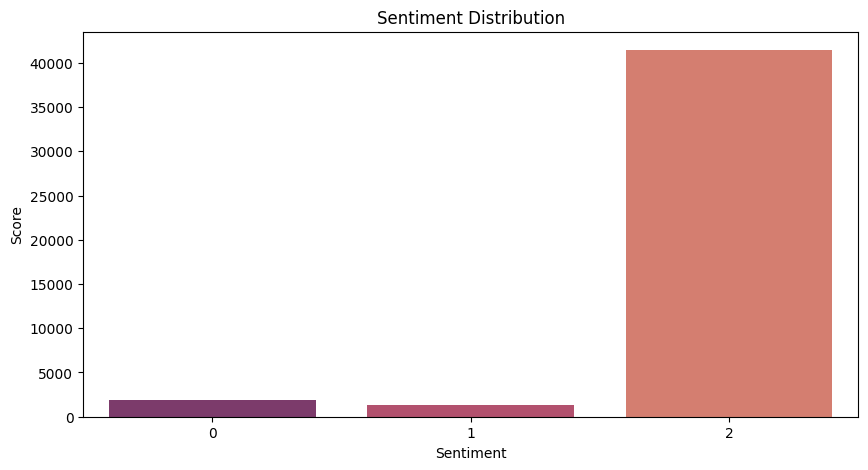

In [17]:
fig = plt.figure(figsize=(10, 5))
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Score')
sns.barplot(x=df['sentiment'].value_counts().keys().to_list(), y=df['sentiment'].value_counts().to_list(), palette='flare_r')

In [18]:
df.rename(columns = {'review content':'content'}, inplace = True)

In [19]:
df.head()

,category,review title,content,rating,sentiment
0,Headsets,Wireless gaming headset,This gaming headset ticks all the boxes # look...,5,2
1,Headsets,"Good for those with a big head, low budget","Easy setup, rated for 6 hours battery but mine...",3,1
2,Headsets,MezumiWireless Gaming Headset,I originally bought this wireless headset for ...,5,2
3,Headsets,HW- S2 great headset.,"This is my 2nd Mezumi headset, It kills the fi...",5,2
4,Headsets,BEST HEADPHONES I'VE PURCHASED IN MY ENTIRE LIFE,This is probably the best headset I've purchas...,5,2


# Preprocessing Data

Kami menggunakan pretrained model bernama bert-base-cased untuk melakukan process NLP (Natural Language Processing).

In [20]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased' # definisikan nama model

In [21]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME) # set token

(…)cased/resolve/main/tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

(…)o/bert-base-cased/resolve/main/vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

(…)t-base-cased/resolve/main/tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

(…)bert-base-cased/resolve/main/config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [22]:
sample_txt = 'I am trying to make sentiment analysis project.'

In [23]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: I am trying to make sentiment analysis project.
   Tokens: ['I', 'am', 'trying', 'to', 'make', 'sentiment', 'analysis', 'project', '.']
Token IDs: [146, 1821, 1774, 1106, 1294, 17024, 3622, 1933, 119]


In [24]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

In [25]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

In [26]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

In [27]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

In [28]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
    pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


dict_keys(['input_ids', 'attention_mask'])

In [29]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([  101,   146,  1821,  1774,  1106,  1294, 17024,  3622,  1933,   119,
          102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0])

In [30]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [31]:

tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'I',
 'am',
 'trying',
 'to',
 'make',
 'sentiment',
 'analysis',
 'project',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [32]:
token_lens = []

for txt in df['content']:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

<ipython-input-33-4dbe9bd8b56e>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(token_lens)


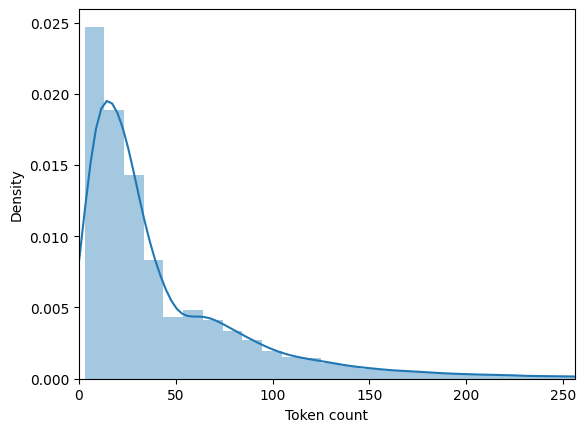

In [33]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [34]:
MAX_LEN = 160

In [35]:
class GPReviewDataset():

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.reviews)

  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [36]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=1337)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=1337)

In [37]:
df_train.shape, df_val.shape, df_test.shape

((35804, 5), (4476, 5), (4476, 5))

In [38]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.content.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=0
  )

In [39]:
BATCH_SIZE = 32

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [40]:
data = next(iter(train_data_loader))
data.keys()

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [41]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([32, 160])
torch.Size([32, 160])
torch.Size([32])


In [42]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [43]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask']
)

In [44]:
bert_model.config.hidden_size

768

In [45]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [46]:
class_names = ['negative', 'neutral', 'positive']

In [47]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [48]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([32, 160])
torch.Size([32, 160])


In [49]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.5222, 0.3266, 0.1512],
        [0.2894, 0.5550, 0.1556],
        [0.2277, 0.5363, 0.2360],
        [0.3341, 0.5118, 0.1541],
        [0.3284, 0.4756, 0.1960],
        [0.3793, 0.3871, 0.2336],
        [0.3447, 0.4835, 0.1718],
        [0.2656, 0.4697, 0.2647],
        [0.2242, 0.5659, 0.2099],
        [0.1551, 0.6144, 0.2305],
        [0.3225, 0.4524, 0.2251],
        [0.2510, 0.4531, 0.2959],
        [0.3804, 0.4061, 0.2136],
        [0.3326, 0.5035, 0.1639],
        [0.3410, 0.5045, 0.1544],
        [0.3286, 0.5009, 0.1705],
        [0.1944, 0.5156, 0.2900],
        [0.2976, 0.4506, 0.2519],
        [0.3186, 0.4852, 0.1962],
        [0.3053, 0.4894, 0.2053],
        [0.3437, 0.4978, 0.1586],
        [0.2207, 0.6329, 0.1464],
        [0.2850, 0.5564, 0.1587],
        [0.3092, 0.5039, 0.1869],
        [0.4388, 0.3578, 0.2034],
        [0.1916, 0.5660, 0.2424],
        [0.2807, 0.5871, 0.1322],
        [0.2440, 0.5014, 0.2545],
        [0.2109, 0.5903, 0.1988],
        [0.181

In [50]:
EPOCHS = 5

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [51]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [52]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [53]:
import warnings

# Suppress specific warnings
warnings.filterwarnings("ignore", message="This DataLoader will create")
warnings.filterwarnings("ignore", message="The `pad_to_max_length` argument is deprecated")

# Your code here
# ...

# Reset the warning filters to default (if needed) after the code block where you want to suppress warnings
warnings.filterwarnings("default")

In [54]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/5
----------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Train loss 0.19932149341654523 accuracy 0.9383588425874204
Val   loss 0.16095805440896324 accuracy 0.9492850759606791

Epoch 2/5
----------
Train loss 0.12681458556173175 accuracy 0.9597531002122668
Val   loss 0.1901826426120741 accuracy 0.9421358355674709

Epoch 3/5
----------
Train loss 0.08669011643806837 accuracy 0.975170372025472
Val   loss 0.24470333545635056 accuracy 0.9443699731903485

Epoch 4/5
----------
Train loss 0.06169334176099269 accuracy 0.9842754999441403
Val   loss 0.27145131702085823 accuracy 0.9445933869526363

Epoch 5/5
----------
Train loss 0.04603185952197672 accuracy 0.9892749413473355
Val   loss 0.29071580611635 accuracy 0.9436997319034852

CPU times: user 1h 14min 39s, sys: 19.3 s, total: 1h 14min 58s
Wall time: 1h 15min 24s


In [57]:
history['train_acc']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[tensor(0.9384, device='cuda:0', dtype=torch.float64),
 tensor(0.9598, device='cuda:0', dtype=torch.float64),
 tensor(0.9752, device='cuda:0', dtype=torch.float64),
 tensor(0.9843, device='cuda:0', dtype=torch.float64),
 tensor(0.9893, device='cuda:0', dtype=torch.float64)]

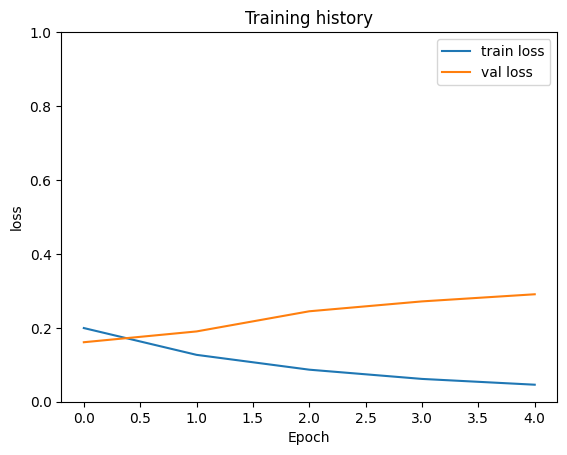

In [77]:
# Plot training and validation accuracy

train_acc_values = [tensor.item() for tensor in history['train_loss']]
train_loss_values = [tensor.item() for tensor in history['val_loss']]

plt.plot(train_acc_values, label='train loss')
plt.plot(train_loss_values, label='val loss')

# Graph chars
plt.title('Training history')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

### Model Evaluation

In [59]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


0.9421358355674709

In [60]:
def get_predictions(model, data_loader):
    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            # Get outouts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()

    return review_texts, predictions, prediction_probs, real_values

In [61]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
    model,
    test_data_loader
)

In [62]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.72      0.61      0.66       198
     neutral       0.36      0.33      0.34       156
    positive       0.97      0.98      0.98      4122

    accuracy                           0.94      4476
   macro avg       0.68      0.64      0.66      4476
weighted avg       0.94      0.94      0.94      4476



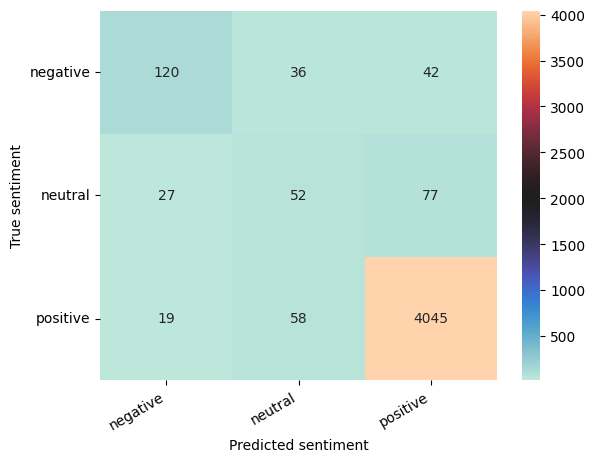

In [68]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="icefire")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

### Predicting on raw text

In [96]:
review_text = input("input your text : ")
encoded_review = tokenizer.encode_plus(
    review_text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',
)
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text     : {review_text}')
print(f'Sentiment       : {class_names[prediction]}')

input your text : i think this model is a bit overfitting but its okay
Review text     : i think this model is a bit overfitting but its okay
Sentiment       : neutral
